In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score

import random, os, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, Dense
from tensorflow.keras import backend as K
import pickle

import matplotlib.pyplot as plt

import sys
sys.path.append("../../../libraries/")
import utils

# Hyperparameters

In [2]:
#%%
seeds = [20, 30, 45, 70]
results = ""
debug = True
balance = True

epochs = 10000
batch_size = 128

################
inputShape = 37
timeStep = 6
#################

layers = [[inputShape, 3, 1], [inputShape, 5, 1], [inputShape, 8, 1], [inputShape, 10, 1], 
          [inputShape, 15, 1], [inputShape, 20, 1],  [inputShape, 25, 1], [inputShape, 30, 1], 
          [inputShape, 35, 1]]
lr_scheduler = [0.0001, 0.001, 0.01, 0.1]
dropout = [0.0, 0.1, 0.2, 0.3]

w2 = 0.18
w1 = 0.82


hyperparameters = {
    "epochs":epochs,
    'batch_size': batch_size,
    "w1":w1, "w2":w2, 
    'maskValue':666,
    'patience':30,
    'monitor': 'val_loss', "mindelta": 0,
    'balance': balance, "timeStep": timeStep,
    'optimizer':'adam',
    'kfold':5,
    'level':3,
    'verbose':0
}

tensor = True
tab = "\t" * hyperparameters["level"]


# Permutation

We load the GRU pre-trained model generated in `EXPERIMENTS/WITHOUT_FS/` The trained model with all the features, as well as the results, are available in the directory `EXPERIMENTS/WITHOUT_FS/Results_GRU/`


In [3]:
features = ['ppeak', 'set_peep',
       'total_peep', 'rr', 'set_rr', 'total_rr', 'set_tv', 'total_tv',
       'set_fio2', 'set_ie_ratio', 'set_pc', 'set_pc_draeger', 'pinsp_draeger',
       'pinsp_hamilton', 'pcv_level', 'calculated_bicarbonate', 'hr', 'pO2',
       'so2', 'pCO2', 'pH', 'heart_rate', 'sbp', 'dbp', 'mbp', 'sbp_ni',
       'dbp_ni', 'mbp_ni', 'temperature', 'spo2', 'glucose', 'vasopressor',
       'crrt', 'invasive', 'noninvasive', 'highflow', 'sofa_24hours']
features = np.array(features)
features

array(['ppeak', 'set_peep', 'total_peep', 'rr', 'set_rr', 'total_rr',
       'set_tv', 'total_tv', 'set_fio2', 'set_ie_ratio', 'set_pc',
       'set_pc_draeger', 'pinsp_draeger', 'pinsp_hamilton', 'pcv_level',
       'calculated_bicarbonate', 'hr', 'pO2', 'so2', 'pCO2', 'pH',
       'heart_rate', 'sbp', 'dbp', 'mbp', 'sbp_ni', 'dbp_ni', 'mbp_ni',
       'temperature', 'spo2', 'glucose', 'vasopressor', 'crrt',
       'invasive', 'noninvasive', 'highflow', 'sofa_24hours'],
      dtype='<U22')

In [4]:
def permutation_time_series(X, k, hyperparameters, seed=None):
    np.random.seed(seed)
    
    v_feature = X[:, :, k].copy()
    stay_length_array = (v_feature == hyperparameters["maskValue"]).sum(axis=1)
    # Only permute the patient with the same length of stay
    for i in range(v_feature.shape[1]):
        v_feature_masked = v_feature[stay_length_array == i]
        np.random.shuffle(v_feature_masked)
        v_feature[stay_length_array == i] = v_feature_masked
    X[:, :, k] = v_feature
    return X


from tensorflow.keras.models import load_model

def load_keras_model(filepath):
    custom_loss = utils.weighted_binary_crossentropy(hyperparameters)
    return load_model(filepath, custom_objects={'loss': custom_loss})

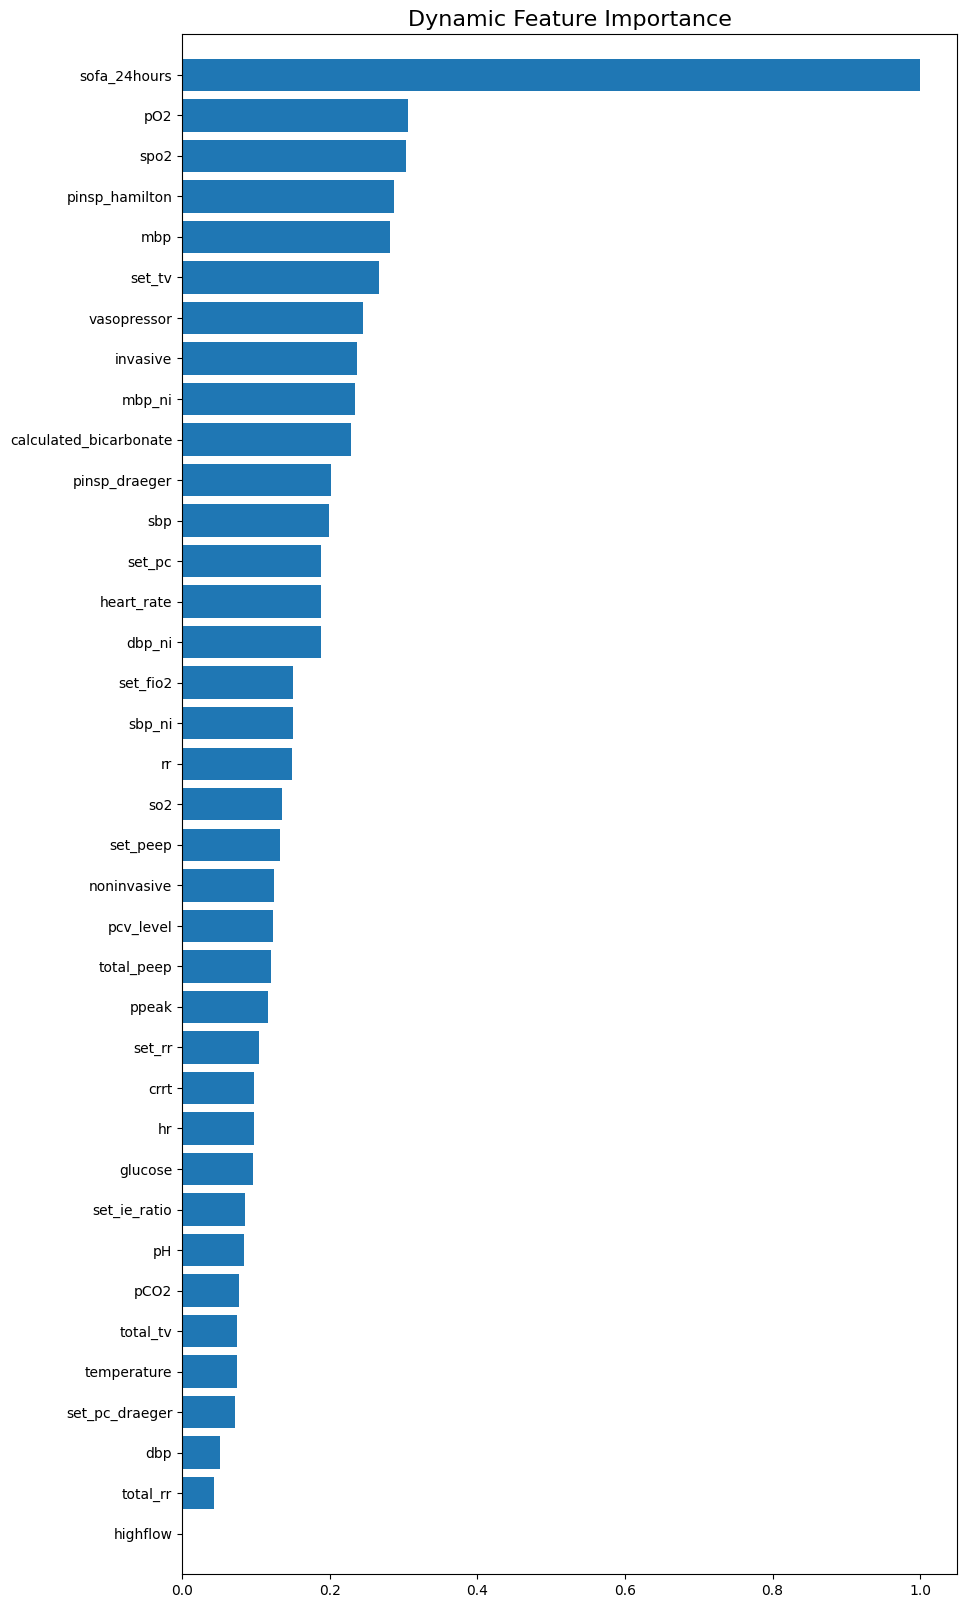

In [5]:
n = 4
seed = 42
results_perm_dyn = []
for i in [0]:
    X_train = np.load("../../../ORIGINAL_DATA/SEPSIS/splits/notbalanced/split_" + str(i) +
                          "/X_train_tensor_" + str(n)+ ".npy")
    y_train = pd.read_csv("../../../ORIGINAL_DATA/SEPSIS/splits/notbalanced/split_" + str(i) +
                          "/y_train_" + str(n)+ ".csv",
                         index_col=0)
    
    X_val = np.load("../../../ORIGINAL_DATA/SEPSIS/splits/notbalanced/split_" + str(i) +
                        "/X_val_tensor_" + str(n)+ ".npy")
    y_val = pd.read_csv("../../../ORIGINAL_DATA/SEPSIS/splits/notbalanced/split_" + str(i) +
                        "/y_val_" + str(n)+ ".csv",
                       index_col=0)

    directory = f'../../../experiments/SEPSIS/considering_all_features/Results_GRU/split_{i}/'
    model = load_keras_model(os.path.join(directory, f"model_split_{i}.h5"))
    
    y_pred = model.predict(X_val, verbose=0) 
    roc_baseline = sklearn.metrics.roc_auc_score(y_val.individualMRGerm.values, y_pred)
    results_perm_dyn = []
    for k in range(features.shape[0]):
        # Shuffle feature K
        save_col = X_val[:,:,k].copy()
        X_val = permutation_time_series(X_val, k, hyperparameters, seed=seed)

        # Compute ROC with feature K shuffled
        y_pred = model.predict(X_val, verbose=0) 
        roc = sklearn.metrics.roc_auc_score(y_val.individualMRGerm.values, y_pred)
        results_perm_dyn.append(roc_baseline - roc)
        X_val[:,:,k] = save_col

    # Display GRU feature importance
    print()
    if i == 0:
        df = pd.DataFrame()
    df["roc_seed_" + str(i)] = results_perm_dyn
    df["features_dyn"] = features
    df = df.set_index("features_dyn")


from sklearn.preprocessing import MinMaxScaler

# Normalize the feature importance values between 0 and 1
scaler = MinMaxScaler()
normalized_importance = scaler.fit_transform(df.mean(axis=1).sort_values().values.reshape(-1, 1)).flatten()
split_directory = './Results_GRU'
# Plot the normalized values
plt.figure(figsize=(10, 20))
plt.barh(np.arange(len(features)), normalized_importance)
plt.yticks(np.arange(len(features)), df.mean(axis=1).sort_values().index.values)
plt.title('Dynamic Feature Importance', size=16)
plt.ylim((-1, len(features)))

output_path = os.path.join(split_directory, "dynamic_feature_importance.pdf")
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()

In [6]:
df["mean_importance"] = df.mean(axis=1)

top_features_dyn = df["mean_importance"].nlargest(5).index.tolist()
print("5 best features:", top_features_dyn)

dynamic = pd.DataFrame(top_features_dyn, columns=['Selected Feature'])

dynamic.to_csv('../Results/GRU_selected_features.csv', index=False)

5 best features: ['sofa_24hours', 'pO2', 'spo2', 'pinsp_hamilton', 'mbp']
